# Train MLP using radar data
Uses derivateive for detrening which allows for online wet dry classification (not published).

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from numpy.lib.stride_tricks import sliding_window_view # for sliding window
import pickle

In [2]:
from sklearn.model_selection import train_test_split
from joblib import Parallel, delayed # parallell code, for faster life.. 
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, matthews_corrcoef, precision_score
import tqdm 
onehot = OneHotEncoder(sparse_output=True)

In [3]:
# Read train dataset (coordinates removed)
ds_cmls = xr.open_dataset("data/train_rad.nc")

# get cml names as numpy array (used in code later)
train_test = ds_cmls.cml_id.data

In [4]:
# Calculate nomralized trsl, this fixes stationarity problems such as sudden change of baseline
ds_cmls['trsl_norm'] = ds_cmls.trsl.diff(dim = 'time', n = 1)

## Determine optimal hyperparameters using crossvalidation

In [5]:
# Define functions for running MLP training in parallell
def train_model(learning_rate, regularization, hidden_layer_sizes, activation, X, Y_onehot, X_val, Y, Y_val):
    dnn = MLPClassifier(learning_rate_init=learning_rate, 
                        alpha=regularization, 
                        #max_iter=600, 
                        activation=activation,
                        solver='adam',
                        verbose=False,
                        hidden_layer_sizes=hidden_layer_sizes)

    dnn.fit(X, Y_onehot)
    dnn_ypred_train = np.array(np.argmax(dnn.predict(X), axis=1)).astype(bool).ravel()  # de one-hot
    dnn_ypred_test = np.array(np.argmax(dnn.predict(X_val), axis=1)).astype(bool).ravel()

    train_mcc = matthews_corrcoef(Y.ravel(), dnn_ypred_train)
    test_mcc = matthews_corrcoef(Y_val.ravel(), dnn_ypred_test)

    return train_mcc, test_mcc

def clf_pred(X, X_val, Y, Y_val, learning_rate, regularization, hidden_layer_sizes, activation):
    Y_onehot = onehot.fit_transform(Y)
    train_mcc = np.zeros((len(learning_rate), len(regularization)))
    test_mcc = np.zeros((len(learning_rate), len(regularization)))

    # Define a function to parallelize
    def process_params(i, j):
        return train_model(learning_rate[i], regularization[j], hidden_layer_sizes, activation, X, Y_onehot, X_val, Y, Y_val)

    # Parallelize the training loop
    results = Parallel(n_jobs=-1)(delayed(process_params)(i, j) for i in range(len(learning_rate)) for j in range(len(regularization)))
    
    # Unpack the results
    for index, (i, j) in enumerate([(i, j) for i in range(len(learning_rate)) for j in range(len(regularization))]):
        train_mcc[i][j], test_mcc[i][j] = results[index]

    return train_mcc, test_mcc

# when training against Norwegian disdrometers it was beneficiary to set window_size to 60
def smooth_binary_array(arr, window_size=1):
    # Create a kernel for smoothing, e.g., [1, 1, 1] for a simple moving average
    kernel = np.ones(window_size, dtype=bool)
    
    # Use convolution to smooth the array
    smoothed_arr = np.convolve(arr, kernel, mode='same')
    
    # Convert non-zero values to True
    smoothed_arr = smoothed_arr > 0
    
    return smoothed_arr

In [6]:
# Define hyperparameters
hidden_layer_sizes = [
    [1],
    [10],
    [20],
    [70],
    [5, 5],
    [10, 10],
    [50, 50],
    [100, 100]
]

learning_rate = np.logspace(-7, 0, 7)
regularization = np.linspace(0, 0.7, 5)

windowsize = 40 # found to be ok

In [7]:
# Setup k-fold crossvalidation
k_splits = 5
from sklearn.model_selection import KFold
kf = KFold(n_splits=k_splits, shuffle=True, random_state=42)
fold_indices = list(kf.split(train_test))

In [8]:
# train mlp on all hyperparameters (this can take several days if you have many hyperparameters)
res_train_xval_relu = np.zeros([len(hidden_layer_sizes), k_splits, learning_rate.size, regularization.size])
res_test_xval_relu = np.zeros([len(hidden_layer_sizes), k_splits, learning_rate.size, regularization.size])

res_train_xval_logistic = np.zeros([len(hidden_layer_sizes), k_splits, learning_rate.size, regularization.size])
res_test_xval_logistic = np.zeros([len(hidden_layer_sizes), k_splits, learning_rate.size, regularization.size])

for j, hls in enumerate(hidden_layer_sizes):    
    for i, (train_idx, val_idx) in enumerate(fold_indices):
        train = train_test[train_idx]    
        test = train_test[val_idx] # validation set

        # prepare TRAIN dataset:
        Y_train = np.vstack(np.array([(ds_cmls.sel(cml_id = train).isel(
            cml_id = i, sublink_id = 0).radar_wet).values.reshape(-1, 1) for i in range(
            ds_cmls.sel(cml_id = train).cml_id.size)]))

        X_train = []
        # append nan to start of array to shift it so that this is a rolling window looking back in time (real time capabilities)
        x_start = np.ones([int(windowsize)-1, windowsize*2])*np.nan

        for link_i in range(ds_cmls.sel(cml_id = train).cml_id.size):
            sliding_window_ch1 = sliding_window_view(ds_cmls.sel(
                cml_id = train).isel(cml_id = link_i, sublink_id = 0).trsl_norm.values, window_shape = windowsize)
            sliding_window_ch2 = sliding_window_view(ds_cmls.sel(
                cml_id = train).isel(cml_id = link_i, sublink_id = 1).trsl_norm.values, window_shape = windowsize)

            X_train.append(np.vstack([x_start, np.hstack([sliding_window_ch1, sliding_window_ch2])]))
        X_train = np.vstack(X_train)
        
        # remove nan
        indices = np.argwhere(~np.isnan(X_train).any(axis = 1)).ravel()
        X_train = X_train[indices, :]
        Y_train = Y_train[indices]
        
        # prepare TEST dataset:
        Y_test = np.vstack(np.array([(ds_cmls.sel(cml_id = test).isel(
            cml_id = i, sublink_id = 0).radar_wet).values.reshape(-1, 1) for i in range(
            ds_cmls.sel(cml_id = test).cml_id.size)]))

        X_test = []
        # append nan to start of array to shift it so that this is a rolling window looking back in time (real time capabilities)
        x_start = np.ones([int(windowsize)-1, windowsize*2])*np.nan 
        #x_end = np.ones([int(windowsize/2)- 1, windowsize*2])*np.nan

        for link_i in range(ds_cmls.sel(cml_id = test).cml_id.size):
            sliding_window_ch1 = sliding_window_view(ds_cmls.sel(
                cml_id = test).isel(cml_id = link_i, sublink_id = 0).trsl_norm.values, window_shape = windowsize)
            sliding_window_ch2 = sliding_window_view(ds_cmls.sel(
                cml_id = test).isel(cml_id = link_i, sublink_id = 1).trsl_norm.values, window_shape = windowsize)

            X_test.append(np.vstack([x_start, np.hstack([sliding_window_ch1, sliding_window_ch2])]))
        X_test = np.vstack(X_test)
        
        # remove places where we have nan
        indices = np.argwhere(~np.isnan(X_test).any(axis = 1)).ravel()
        X_test = X_test[indices, :]
        Y_test = Y_test[indices]

        # TRain on 50/50 wet/dry and include dry close to wet as wet
        # set minutes close to rain as wet, select 50/50 wet dry 
        smoothed_rain = smooth_binary_array(Y_train.ravel(), window_size=30)
        indices_rain = np.where(smoothed_rain)[0]
        indices_norain = np.where(~smoothed_rain)[0]
        
        # select some random dry events
        indices_norain = np.random.choice(indices_norain, size = np.sum(smoothed_rain), replace = False, p = None)
        X_train = np.vstack([X_train[indices_norain, :], X_train[indices_rain, :]])
        Y_train = np.vstack([Y_train[indices_norain, :], Y_train[indices_rain, :]])
        
        res_train, res_test = clf_pred(X_train, X_test, Y_train, Y_test, learning_rate, regularization, hls, 'relu')
        res_train_xval_relu[j, i] = res_train
        res_test_xval_relu[j, i] = res_test

        res_train, res_test = clf_pred(X_train, X_test, Y_train, Y_test, learning_rate, regularization, hls, 'logistic')
        res_train_xval_logistic[j, i] = res_train
        res_test_xval_logistic[j, i] = res_test
        print(train)
        print(test)
        print(hls)
        print(learning_rate)
        print(regularization)
        print(res_train)
        print(res_test)
        
        print('#######################################################')

/home/erlend/miniforge3/envs/pycomlink-dev/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/erlend/miniforge3/envs/pycomlink-dev/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/erlend/miniforge3/envs/pycomlink-dev/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/erlend/miniforge3/envs/pycomlink-dev/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimiza

['1' '2' '3' '4' '5' '6' '7' '10' '12' '13' '14' '15' '17' '18' '19' '20'
 '21' '22' '23' '25']
['0' '8' '9' '11' '16' '24']
[1]
[1.00000000e-07 1.46779927e-06 2.15443469e-05 3.16227766e-04
 4.64158883e-03 6.81292069e-02 1.00000000e+00]
[0.    0.175 0.35  0.525 0.7  ]
[[ 0.         -0.05610789  0.          0.          0.        ]
 [ 0.          0.         -0.03882489  0.          0.        ]
 [ 0.42107483  0.34150944  0.3809393   0.35155253  0.27202233]
 [ 0.50466162  0.48998678  0.46346657  0.45922252  0.44255999]
 [ 0.50847891  0.49154725  0.4762968   0.45682144  0.44463807]
 [ 0.50513283  0.4643436   0.44744491  0.42312569  0.39976478]
 [ 0.48788606  0.          0.          0.          0.        ]]
[[ 0.         -0.05938427  0.          0.          0.        ]
 [ 0.          0.         -0.04390119  0.          0.        ]
 [ 0.4723797   0.38443237  0.42840511  0.39274968  0.29905353]
 [ 0.51106329  0.53030285  0.50841988  0.51237814  0.49760673]
 [ 0.49275412  0.52344198  0.52101124

/home/erlend/miniforge3/envs/pycomlink-dev/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/erlend/miniforge3/envs/pycomlink-dev/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/erlend/miniforge3/envs/pycomlink-dev/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/erlend/miniforge3/envs/pycomlink-dev/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimiza

['0' '3' '4' '6' '7' '8' '9' '10' '11' '12' '14' '15' '16' '17' '18' '19'
 '20' '21' '22' '24' '25']
['1' '2' '5' '13' '23']
[1]
[1.00000000e-07 1.46779927e-06 2.15443469e-05 3.16227766e-04
 4.64158883e-03 6.81292069e-02 1.00000000e+00]
[0.    0.175 0.35  0.525 0.7  ]
[[-0.04906621  0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.        ]
 [ 0.39489926  0.39455106  0.4288539   0.30850964  0.25594369]
 [ 0.5024686   0.49105006  0.4773829   0.46159875  0.44448411]
 [ 0.50621501  0.48870752  0.48025207  0.45679805  0.44825619]
 [ 0.49590837  0.46975449  0.44554696  0.44990709  0.40406633]
 [ 0.47994809  0.          0.          0.          0.        ]]
[[-0.05132123  0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.        ]
 [ 0.4596561   0.44811089  0.47825261  0.36472601  0.30442759]
 [ 0.54853632  0.54421251  0.53168355  0.5183995   0.50179195]
 [ 0.54280102  0.54041842  0.53210364

/home/erlend/miniforge3/envs/pycomlink-dev/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/erlend/miniforge3/envs/pycomlink-dev/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/erlend/miniforge3/envs/pycomlink-dev/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/erlend/miniforge3/envs/pycomlink-dev/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimiza

['0' '1' '2' '5' '6' '7' '8' '9' '10' '11' '13' '14' '16' '17' '18' '19'
 '20' '22' '23' '24' '25']
['3' '4' '12' '15' '21']
[1]
[1.00000000e-07 1.46779927e-06 2.15443469e-05 3.16227766e-04
 4.64158883e-03 6.81292069e-02 1.00000000e+00]
[0.    0.175 0.35  0.525 0.7  ]
[[-0.05136547  0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.        ]
 [ 0.40241887  0.35840586  0.32430228  0.33446951  0.        ]
 [ 0.50236892  0.49089805  0.47599666  0.46046565  0.42838387]
 [ 0.50631014  0.49290035  0.47452949  0.456771    0.45089361]
 [ 0.49676733  0.46318583  0.4388051   0.43682931  0.41714035]
 [ 0.48199147  0.          0.          0.          0.        ]]
[[-0.03401205  0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.        ]
 [ 0.46580614  0.42275898  0.38468598  0.39380716  0.        ]
 [ 0.53281687  0.54073511  0.5319181   0.51895412  0.48520992]
 [ 0.52044622  0.53679333  0.53021593

/home/erlend/miniforge3/envs/pycomlink-dev/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/erlend/miniforge3/envs/pycomlink-dev/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/erlend/miniforge3/envs/pycomlink-dev/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/erlend/miniforge3/envs/pycomlink-dev/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimiza

['0' '1' '2' '3' '4' '5' '6' '7' '8' '9' '10' '11' '12' '13' '14' '15'
 '16' '19' '21' '23' '24']
['17' '18' '20' '22' '25']
[1]
[1.00000000e-07 1.46779927e-06 2.15443469e-05 3.16227766e-04
 4.64158883e-03 6.81292069e-02 1.00000000e+00]
[0.    0.175 0.35  0.525 0.7  ]
[[-0.09495587 -0.08791409 -0.03524314 -0.06669151  0.        ]
 [ 0.          0.          0.          0.00899475  0.        ]
 [ 0.44726289  0.36952053  0.41204368  0.3488213   0.29881378]
 [ 0.50652597  0.49379236  0.47884113  0.4625624   0.44526131]
 [ 0.50994186  0.49345699  0.4793219   0.46124039  0.44345658]
 [ 0.50539052  0.47180128  0.43964424  0.43183023  0.42416342]
 [ 0.48968285  0.          0.          0.          0.        ]]
[[-0.0445971  -0.10752512 -0.03215829 -0.03458852  0.        ]
 [ 0.          0.          0.          0.01832449  0.        ]
 [ 0.5004636   0.4106258   0.4667592   0.388875    0.33202944]
 [ 0.52362416  0.53392306  0.52661982  0.51382554  0.49635242]
 [ 0.50964218  0.53288444  0.52518524

/home/erlend/miniforge3/envs/pycomlink-dev/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/erlend/miniforge3/envs/pycomlink-dev/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/erlend/miniforge3/envs/pycomlink-dev/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/erlend/miniforge3/envs/pycomlink-dev/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimiza

['0' '1' '2' '3' '4' '5' '8' '9' '11' '12' '13' '15' '16' '17' '18' '20'
 '21' '22' '23' '24' '25']
['6' '7' '10' '14' '19']
[1]
[1.00000000e-07 1.46779927e-06 2.15443469e-05 3.16227766e-04
 4.64158883e-03 6.81292069e-02 1.00000000e+00]
[0.    0.175 0.35  0.525 0.7  ]
[[ 0.          0.07723162  0.          0.04924311 -0.07197769]
 [ 0.          0.          0.          0.          0.        ]
 [ 0.39542033  0.25185844  0.24484292  0.29350088  0.09884855]
 [ 0.49912544  0.48806518  0.47327476  0.45840387  0.44137442]
 [ 0.50319523  0.48881342  0.4742345   0.45784876  0.4439894 ]
 [ 0.49808919  0.46383873  0.45209533  0.42742412  0.39877942]
 [ 0.48193288  0.          0.          0.          0.        ]]
[[ 0.          0.086001    0.          0.07288383 -0.10909266]
 [ 0.          0.          0.          0.          0.        ]
 [ 0.44751753  0.29680558  0.29032421  0.34028249  0.13492958]
 [ 0.55121685  0.54185888  0.52638031  0.50964421  0.49479551]
 [ 0.55160601  0.54008107  0.52628814

/home/erlend/miniforge3/envs/pycomlink-dev/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/erlend/miniforge3/envs/pycomlink-dev/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/erlend/miniforge3/envs/pycomlink-dev/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/erlend/miniforge3/envs/pycomlink-dev/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimiza

['1' '2' '3' '4' '5' '6' '7' '10' '12' '13' '14' '15' '17' '18' '19' '20'
 '21' '22' '23' '25']
['0' '8' '9' '11' '16' '24']
[10]
[1.00000000e-07 1.46779927e-06 2.15443469e-05 3.16227766e-04
 4.64158883e-03 6.81292069e-02 1.00000000e+00]
[0.    0.175 0.35  0.525 0.7  ]
[[0.00359073 0.         0.049294   0.01868433 0.0382989 ]
 [0.         0.03232399 0.         0.03311288 0.00802922]
 [0.47496061 0.46800581 0.44135141 0.40937412 0.40036422]
 [0.60268243 0.55241568 0.50975274 0.4839235  0.45594715]
 [0.61076306 0.55981036 0.52293915 0.49051586 0.45521525]
 [0.5994115  0.50527491 0.48673171 0.4565873  0.41966966]
 [0.52006307 0.         0.         0.         0.        ]]
[[0.         0.         0.0392425  0.01617977 0.04917326]
 [0.         0.01389304 0.         0.02122213 0.        ]
 [0.5267196  0.51990675 0.49060974 0.45668591 0.44839012]
 [0.59752761 0.59119857 0.55892097 0.52985545 0.50342063]
 [0.59631934 0.59288615 0.56662854 0.53803862 0.50447193]
 [0.56196228 0.48788634 0.4822596

/home/erlend/miniforge3/envs/pycomlink-dev/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/erlend/miniforge3/envs/pycomlink-dev/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/erlend/miniforge3/envs/pycomlink-dev/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/erlend/miniforge3/envs/pycomlink-dev/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimiza

['0' '3' '4' '6' '7' '8' '9' '10' '11' '12' '14' '15' '16' '17' '18' '19'
 '20' '21' '22' '24' '25']
['1' '2' '5' '13' '23']
[10]
[1.00000000e-07 1.46779927e-06 2.15443469e-05 3.16227766e-04
 4.64158883e-03 6.81292069e-02 1.00000000e+00]
[0.    0.175 0.35  0.525 0.7  ]
[[-0.04556622  0.05546335  0.          0.          0.01137664]
 [ 0.07162616  0.          0.          0.          0.        ]
 [ 0.49946516  0.48165807  0.4203367   0.40613591  0.39281601]
 [ 0.60028475  0.56197992  0.52492269  0.49244833  0.46142295]
 [ 0.61380324  0.56934284  0.53109669  0.48246614  0.4652353 ]
 [ 0.60237107  0.53067808  0.4806143   0.45626012  0.42341407]
 [ 0.5153813   0.          0.          0.          0.        ]]
[[-0.05671134  0.07316999  0.          0.          0.01269065]
 [ 0.09145494  0.          0.          0.          0.        ]
 [ 0.54182926  0.52058976  0.47471889  0.45939837  0.44669799]
 [ 0.60649055  0.59240475  0.56624097  0.54004299  0.51179922]
 [ 0.61768933  0.60129148  0.5711344

/home/erlend/miniforge3/envs/pycomlink-dev/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/erlend/miniforge3/envs/pycomlink-dev/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/erlend/miniforge3/envs/pycomlink-dev/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/erlend/miniforge3/envs/pycomlink-dev/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimiza

['0' '1' '2' '5' '6' '7' '8' '9' '10' '11' '13' '14' '16' '17' '18' '19'
 '20' '22' '23' '24' '25']
['3' '4' '12' '15' '21']
[10]
[1.00000000e-07 1.46779927e-06 2.15443469e-05 3.16227766e-04
 4.64158883e-03 6.81292069e-02 1.00000000e+00]
[0.    0.175 0.35  0.525 0.7  ]
[[ 0.00510546 -0.07071597  0.01197369  0.06597068  0.01728133]
 [ 0.          0.          0.00510546  0.          0.00510546]
 [ 0.48096467  0.4373158   0.42461809  0.3734543   0.36966664]
 [ 0.59880054  0.56169689  0.5197609   0.48524066  0.45286936]
 [ 0.6127254   0.56326846  0.53245251  0.48549816  0.45376199]
 [ 0.60380182  0.51378853  0.48310136  0.45334887  0.41206179]
 [ 0.50986179  0.          0.          0.          0.        ]]
[[ 0.00774082 -0.06620357  0.01896126  0.0444426   0.00986353]
 [ 0.          0.          0.00774082  0.          0.        ]
 [ 0.53007234  0.49234095  0.48365385  0.436034    0.42544875]
 [ 0.60928806  0.60460734  0.56835373  0.53389099  0.50761701]
 [ 0.60758366  0.61284867  0.5818053

/home/erlend/miniforge3/envs/pycomlink-dev/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/erlend/miniforge3/envs/pycomlink-dev/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/erlend/miniforge3/envs/pycomlink-dev/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/erlend/miniforge3/envs/pycomlink-dev/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimiza

['0' '1' '2' '3' '4' '5' '6' '7' '8' '9' '10' '11' '12' '13' '14' '15'
 '16' '19' '21' '23' '24']
['17' '18' '20' '22' '25']
[10]
[1.00000000e-07 1.46779927e-06 2.15443469e-05 3.16227766e-04
 4.64158883e-03 6.81292069e-02 1.00000000e+00]
[0.    0.175 0.35  0.525 0.7  ]
[[-0.05770712  0.0034935  -0.00444172  0.00783158  0.00311512]
 [ 0.          0.08549015  0.          0.          0.        ]
 [ 0.50421181  0.47715294  0.44728694  0.40584517  0.39282108]
 [ 0.60365584  0.5648242   0.52212965  0.48651981  0.45763622]
 [ 0.61912645  0.5735537   0.52791946  0.48878786  0.46286513]
 [ 0.58831783  0.51596955  0.48673752  0.47580409  0.4284764 ]
 [ 0.5610713   0.          0.          0.          0.        ]]
[[-0.06269475  0.         -0.00515964  0.00987299  0.00987299]
 [ 0.          0.09413117  0.          0.          0.        ]
 [ 0.55024158  0.5321659   0.5019095   0.44987356  0.43826699]
 [ 0.59263293  0.58784388  0.56135742  0.54194035  0.50716691]
 [ 0.59913907  0.5959898   0.5668854

/home/erlend/miniforge3/envs/pycomlink-dev/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/erlend/miniforge3/envs/pycomlink-dev/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/erlend/miniforge3/envs/pycomlink-dev/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/erlend/miniforge3/envs/pycomlink-dev/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimiza

['0' '1' '2' '3' '4' '5' '8' '9' '11' '12' '13' '15' '16' '17' '18' '20'
 '21' '22' '23' '24' '25']
['6' '7' '10' '14' '19']
[10]
[1.00000000e-07 1.46779927e-06 2.15443469e-05 3.16227766e-04
 4.64158883e-03 6.81292069e-02 1.00000000e+00]
[0.    0.175 0.35  0.525 0.7  ]
[[ 0.07322644  0.         -0.09970166  0.00357222  0.02190208]
 [ 0.03666498  0.01557177  0.          0.03448177  0.        ]
 [ 0.47059183  0.4316802   0.42648958  0.39931961  0.37449516]
 [ 0.59368899  0.56116123  0.5130501   0.48260735  0.44771276]
 [ 0.60231389  0.56763717  0.52256816  0.47805315  0.45813877]
 [ 0.59370913  0.5035321   0.4791138   0.46329856  0.43391576]
 [ 0.51920066  0.          0.          0.          0.        ]]
[[ 0.05785718  0.         -0.1449925   0.          0.02960729]
 [ 0.0553765   0.02678784  0.          0.05418522  0.        ]
 [ 0.52587613  0.49339775  0.48730777  0.4590878   0.42867646]
 [ 0.6305981   0.61119442  0.57331675  0.53671546  0.50759892]
 [ 0.64029786  0.61363888  0.5786197

/home/erlend/miniforge3/envs/pycomlink-dev/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/erlend/miniforge3/envs/pycomlink-dev/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/erlend/miniforge3/envs/pycomlink-dev/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/erlend/miniforge3/envs/pycomlink-dev/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimiza

['1' '2' '3' '4' '5' '6' '7' '10' '12' '13' '14' '15' '17' '18' '19' '20'
 '21' '22' '23' '25']
['0' '8' '9' '11' '16' '24']
[20]
[1.00000000e-07 1.46779927e-06 2.15443469e-05 3.16227766e-04
 4.64158883e-03 6.81292069e-02 1.00000000e+00]
[0.    0.175 0.35  0.525 0.7  ]
[[0.01906307 0.00944825 0.02435668 0.00359073 0.00359073]
 [0.11184449 0.07683774 0.11531646 0.03890258 0.0586371 ]
 [0.49633903 0.4583316  0.43693927 0.40923829 0.39178005]
 [0.61587779 0.56701847 0.52242217 0.48079024 0.4560458 ]
 [0.6299127  0.56903705 0.51835262 0.47969557 0.46246899]
 [0.62148315 0.50586433 0.50324643 0.45642023 0.42101091]
 [0.48949533 0.         0.         0.         0.        ]]
[[0.02071064 0.00533678 0.01389304 0.         0.        ]
 [0.10791706 0.06260278 0.11259199 0.02660355 0.04608063]
 [0.5465059  0.50927328 0.48310808 0.45763488 0.43739812]
 [0.61003721 0.59588749 0.56993007 0.5325863  0.50286411]
 [0.60167579 0.59344129 0.56161969 0.53069744 0.5094748 ]
 [0.55100141 0.4535184  0.4673456

/home/erlend/miniforge3/envs/pycomlink-dev/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/erlend/miniforge3/envs/pycomlink-dev/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/erlend/miniforge3/envs/pycomlink-dev/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/erlend/miniforge3/envs/pycomlink-dev/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimiza

['0' '3' '4' '6' '7' '8' '9' '10' '11' '12' '14' '15' '16' '17' '18' '19'
 '20' '21' '22' '24' '25']
['1' '2' '5' '13' '23']
[20]
[1.00000000e-07 1.46779927e-06 2.15443469e-05 3.16227766e-04
 4.64158883e-03 6.81292069e-02 1.00000000e+00]
[0.    0.175 0.35  0.525 0.7  ]
[[0.04225512 0.         0.04946972 0.00153323 0.09727606]
 [0.11387848 0.02782978 0.07298935 0.05301102 0.06457085]
 [0.48792039 0.46571395 0.43975951 0.41113409 0.39283306]
 [0.61603048 0.57090838 0.5210571  0.4850327  0.46221721]
 [0.63203302 0.5726822  0.53185347 0.49176557 0.47222304]
 [0.62360297 0.52126312 0.46993439 0.44133795 0.44518606]
 [0.51323621 0.         0.         0.         0.        ]]
[[0.05186442 0.         0.0584572  0.00897363 0.10261089]
 [0.1517002  0.02538078 0.08783418 0.0559589  0.07337533]
 [0.5255163  0.51012464 0.48635163 0.46482661 0.44672638]
 [0.62116443 0.60190385 0.5632695  0.53865959 0.51441764]
 [0.61832052 0.60168958 0.57170069 0.53729933 0.51959401]
 [0.57870321 0.52260334 0.5004988

/home/erlend/miniforge3/envs/pycomlink-dev/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/erlend/miniforge3/envs/pycomlink-dev/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/erlend/miniforge3/envs/pycomlink-dev/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/erlend/miniforge3/envs/pycomlink-dev/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimiza

['0' '1' '2' '5' '6' '7' '8' '9' '10' '11' '13' '14' '16' '17' '18' '19'
 '20' '22' '23' '24' '25']
['3' '4' '12' '15' '21']
[20]
[1.00000000e-07 1.46779927e-06 2.15443469e-05 3.16227766e-04
 4.64158883e-03 6.81292069e-02 1.00000000e+00]
[0.    0.175 0.35  0.525 0.7  ]
[[ 0.00791423  0.          0.03868938 -0.03940991  0.        ]
 [ 0.09012239  0.10236371  0.03857837  0.04822385  0.04767926]
 [ 0.49339858  0.46286081  0.4289173   0.41456326  0.3801184 ]
 [ 0.61302348  0.56518096  0.52272493  0.48935302  0.45798071]
 [ 0.63022706  0.56398652  0.53121428  0.47909056  0.45367203]
 [ 0.62631977  0.49952421  0.48172493  0.4567235   0.42403501]
 [ 0.52106004  0.          0.          0.          0.        ]]
[[ 0.01418783  0.01094719  0.01600065 -0.05235367  0.        ]
 [ 0.10869566  0.11771138  0.05419159  0.06477441  0.06523559]
 [ 0.5440252   0.51722688  0.48455106  0.47033659  0.43476365]
 [ 0.62775016  0.61410593  0.57262657  0.53740032  0.51287855]
 [ 0.62249758  0.61349307  0.5809721

/home/erlend/miniforge3/envs/pycomlink-dev/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/erlend/miniforge3/envs/pycomlink-dev/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/erlend/miniforge3/envs/pycomlink-dev/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/erlend/miniforge3/envs/pycomlink-dev/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimiza

['0' '1' '2' '3' '4' '5' '6' '7' '8' '9' '10' '11' '12' '13' '14' '15'
 '16' '19' '21' '23' '24']
['17' '18' '20' '22' '25']
[20]
[1.00000000e-07 1.46779927e-06 2.15443469e-05 3.16227766e-04
 4.64158883e-03 6.81292069e-02 1.00000000e+00]
[0.    0.175 0.35  0.525 0.7  ]
[[-0.02589025  0.03416124  0.          0.          0.00494056]
 [ 0.12660536  0.10991004  0.03353744  0.05406881  0.03476931]
 [ 0.50761348  0.47110508  0.44639442  0.42213869  0.38965002]
 [ 0.62174703  0.57112725  0.53653629  0.48875509  0.45361335]
 [ 0.64019478  0.57773433  0.52362603  0.49077717  0.46338701]
 [ 0.62087051  0.52650176  0.46272062  0.44642825  0.39348087]
 [ 0.56165814  0.          0.          0.          0.        ]]
[[-1.45905039e-02  4.25989834e-02 -5.27304421e-04  0.00000000e+00
   8.81387647e-03]
 [ 1.41625437e-01  1.21508456e-01  3.73955882e-02  5.97848707e-02
   3.94185943e-02]
 [ 5.49569239e-01  5.21104226e-01  4.97687851e-01  4.70926018e-01
   4.32230894e-01]
 [ 6.03312281e-01  5.94983061e-01

/home/erlend/miniforge3/envs/pycomlink-dev/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/erlend/miniforge3/envs/pycomlink-dev/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/erlend/miniforge3/envs/pycomlink-dev/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/erlend/miniforge3/envs/pycomlink-dev/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimiza

['0' '1' '2' '3' '4' '5' '8' '9' '11' '12' '13' '15' '16' '17' '18' '20'
 '21' '22' '23' '24' '25']
['6' '7' '10' '14' '19']
[20]
[1.00000000e-07 1.46779927e-06 2.15443469e-05 3.16227766e-04
 4.64158883e-03 6.81292069e-02 1.00000000e+00]
[0.    0.175 0.35  0.525 0.7  ]
[[0.02061574 0.01106894 0.00357222 0.0056737  0.0983005 ]
 [0.09239942 0.06956171 0.10123817 0.03916499 0.07056775]
 [0.49098147 0.45335138 0.41894339 0.40914315 0.38673387]
 [0.61318636 0.56585101 0.52183007 0.47988879 0.45206723]
 [0.62773221 0.56045189 0.5208582  0.4894478  0.46504624]
 [0.61069462 0.50872641 0.47494137 0.43977749 0.43816882]
 [0.52968532 0.         0.         0.         0.        ]]
[[ 3.12446774e-02  1.50375549e-02 -7.89318785e-04 -5.58131407e-04
   8.31343944e-02]
 [ 1.23993198e-01  9.85403035e-02  1.33143478e-01  6.15178730e-02
   1.03391957e-01]
 [ 5.43708294e-01  5.14831171e-01  4.86180134e-01  4.74269634e-01
   4.46413599e-01]
 [ 6.46088561e-01  6.10853500e-01  5.79424151e-01  5.41166777e-01
  

/home/erlend/miniforge3/envs/pycomlink-dev/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/erlend/miniforge3/envs/pycomlink-dev/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/erlend/miniforge3/envs/pycomlink-dev/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/erlend/miniforge3/envs/pycomlink-dev/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimiza

['1' '2' '3' '4' '5' '6' '7' '10' '12' '13' '14' '15' '17' '18' '19' '20'
 '21' '22' '23' '25']
['0' '8' '9' '11' '16' '24']
[70]
[1.00000000e-07 1.46779927e-06 2.15443469e-05 3.16227766e-04
 4.64158883e-03 6.81292069e-02 1.00000000e+00]
[0.    0.175 0.35  0.525 0.7  ]
[[ 0.          0.         -0.00158934  0.          0.00359073]
 [ 0.20700987  0.17592429  0.16663862  0.15295631  0.11675098]
 [ 0.49484158  0.45050203  0.42650715  0.39787372  0.36456612]
 [ 0.64920001  0.57063658  0.51689141  0.48262252  0.46455353]
 [ 0.68754154  0.56661773  0.52025657  0.48780794  0.45920348]
 [ 0.65417511  0.51176947  0.49554565  0.44945627  0.38474819]
 [ 0.51916666  0.          0.          0.          0.        ]]
[[0.         0.         0.         0.         0.        ]
 [0.22485085 0.18825305 0.17802481 0.15640732 0.11569682]
 [0.54578042 0.49888097 0.47515869 0.44398006 0.40744215]
 [0.61005959 0.60036911 0.56853619 0.53334391 0.51370555]
 [0.5698811  0.58795383 0.56393759 0.53269129 0.50759032

/home/erlend/miniforge3/envs/pycomlink-dev/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/erlend/miniforge3/envs/pycomlink-dev/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/erlend/miniforge3/envs/pycomlink-dev/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/erlend/miniforge3/envs/pycomlink-dev/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimiza

['0' '3' '4' '6' '7' '8' '9' '10' '11' '12' '14' '15' '16' '17' '18' '19'
 '20' '21' '22' '24' '25']
['1' '2' '5' '13' '23']
[70]
[1.00000000e-07 1.46779927e-06 2.15443469e-05 3.16227766e-04
 4.64158883e-03 6.81292069e-02 1.00000000e+00]
[0.    0.175 0.35  0.525 0.7  ]
[[0.         0.         0.05166234 0.         0.        ]
 [0.18281372 0.18206719 0.1431523  0.13329867 0.09962114]
 [0.50248787 0.45873692 0.42585707 0.39334188 0.37680046]
 [0.65072499 0.56885504 0.53210244 0.48846167 0.45881571]
 [0.68728887 0.57111638 0.54111387 0.4926543  0.46571769]
 [0.65049953 0.51539859 0.48403323 0.47034603 0.405735  ]
 [0.50984883 0.         0.         0.         0.        ]]
[[ 0.00000000e+00 -5.03213623e-04  5.67467178e-02  0.00000000e+00
   0.00000000e+00]
 [ 2.25539957e-01  2.22820683e-01  1.86311135e-01  1.76772145e-01
   1.28429891e-01]
 [ 5.37372273e-01  5.07394334e-01  4.76261344e-01  4.45879064e-01
   4.26832430e-01]
 [ 6.21430202e-01  5.99096626e-01  5.72354718e-01  5.35386707e-01
  

/home/erlend/miniforge3/envs/pycomlink-dev/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/erlend/miniforge3/envs/pycomlink-dev/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/erlend/miniforge3/envs/pycomlink-dev/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/erlend/miniforge3/envs/pycomlink-dev/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimiza

['0' '1' '2' '5' '6' '7' '8' '9' '10' '11' '13' '14' '16' '17' '18' '19'
 '20' '22' '23' '24' '25']
['3' '4' '12' '15' '21']
[70]
[1.00000000e-07 1.46779927e-06 2.15443469e-05 3.16227766e-04
 4.64158883e-03 6.81292069e-02 1.00000000e+00]
[0.    0.175 0.35  0.525 0.7  ]
[[0.00510546 0.00465911 0.         0.         0.        ]
 [0.18580985 0.17042417 0.15992329 0.13051975 0.12169665]
 [0.4945773  0.45607635 0.41628797 0.40356327 0.35767588]
 [0.64847268 0.56211191 0.52727034 0.48489186 0.45042952]
 [0.68871057 0.56937261 0.52095048 0.49590616 0.46196085]
 [0.65296888 0.5246103  0.48643899 0.44740704 0.43428389]
 [0.50425264 0.         0.         0.         0.        ]]
[[0.         0.00774082 0.         0.         0.        ]
 [0.21637527 0.19673715 0.18044756 0.1446384  0.13563306]
 [0.5442944  0.50816004 0.47340226 0.45905179 0.4120955 ]
 [0.62780894 0.61562704 0.57844876 0.53751063 0.5078219 ]
 [0.58119156 0.61428631 0.57189455 0.54782803 0.51469159]
 [0.57505532 0.53486432 0.4987016

/home/erlend/miniforge3/envs/pycomlink-dev/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/erlend/miniforge3/envs/pycomlink-dev/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/erlend/miniforge3/envs/pycomlink-dev/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/erlend/miniforge3/envs/pycomlink-dev/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimiza

['0' '1' '2' '3' '4' '5' '6' '7' '8' '9' '10' '11' '12' '13' '14' '15'
 '16' '19' '21' '23' '24']
['17' '18' '20' '22' '25']
[70]
[1.00000000e-07 1.46779927e-06 2.15443469e-05 3.16227766e-04
 4.64158883e-03 6.81292069e-02 1.00000000e+00]
[0.    0.175 0.35  0.525 0.7  ]
[[0.         0.         0.         0.         0.        ]
 [0.18657759 0.18850419 0.16101004 0.13393145 0.14103473]
 [0.49908793 0.45673043 0.43145171 0.39850036 0.37230681]
 [0.6598816  0.5776458  0.52551765 0.48584304 0.46685   ]
 [0.69263321 0.57223896 0.52899459 0.4841441  0.47118693]
 [0.65929944 0.519886   0.48859289 0.44994442 0.40351953]
 [0.53515766 0.         0.         0.         0.        ]]
[[0.         0.         0.         0.         0.        ]
 [0.21536051 0.21501452 0.18309513 0.15372809 0.16450144]
 [0.54282629 0.50743947 0.48151989 0.44558047 0.41253938]
 [0.61008686 0.59858729 0.56866669 0.53895075 0.52400612]
 [0.57824377 0.59647654 0.57106904 0.5388047  0.5263143 ]
 [0.56605687 0.4965337  0.4997262

/home/erlend/miniforge3/envs/pycomlink-dev/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/erlend/miniforge3/envs/pycomlink-dev/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/erlend/miniforge3/envs/pycomlink-dev/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/erlend/miniforge3/envs/pycomlink-dev/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimiza

['0' '1' '2' '3' '4' '5' '8' '9' '11' '12' '13' '15' '16' '17' '18' '20'
 '21' '22' '23' '24' '25']
['6' '7' '10' '14' '19']
[70]
[1.00000000e-07 1.46779927e-06 2.15443469e-05 3.16227766e-04
 4.64158883e-03 6.81292069e-02 1.00000000e+00]
[0.    0.175 0.35  0.525 0.7  ]
[[0.         0.         0.         0.         0.        ]
 [0.1920109  0.17451483 0.15576641 0.1277809  0.11180219]
 [0.49381488 0.44975657 0.4135162  0.38576279 0.35661922]
 [0.64943873 0.56407568 0.52371089 0.47795494 0.45579797]
 [0.68019532 0.56232812 0.52411298 0.48949156 0.44664784]
 [0.62623204 0.4984659  0.46440705 0.45465829 0.40467482]
 [0.48052375 0.         0.         0.         0.        ]]
[[0.         0.         0.         0.         0.        ]
 [0.22720353 0.20902206 0.19069448 0.16031527 0.14285671]
 [0.54445833 0.50963491 0.47943082 0.44792099 0.41450774]
 [0.645552   0.61133688 0.5803353  0.54132826 0.5162889 ]
 [0.62993424 0.60889025 0.58184866 0.55260607 0.50688722]
 [0.61111529 0.54233266 0.5314483

/home/erlend/miniforge3/envs/pycomlink-dev/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/erlend/miniforge3/envs/pycomlink-dev/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/erlend/miniforge3/envs/pycomlink-dev/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/erlend/miniforge3/envs/pycomlink-dev/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimiza

['1' '2' '3' '4' '5' '6' '7' '10' '12' '13' '14' '15' '17' '18' '19' '20'
 '21' '22' '23' '25']
['0' '8' '9' '11' '16' '24']
[5, 5]
[1.00000000e-07 1.46779927e-06 2.15443469e-05 3.16227766e-04
 4.64158883e-03 6.81292069e-02 1.00000000e+00]
[0.    0.175 0.35  0.525 0.7  ]
[[0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.51256464 0.47524177 0.         0.         0.        ]
 [0.58393795 0.56069382 0.5356858  0.         0.        ]
 [0.59259937 0.56604374 0.52766345 0.5067232  0.49201925]
 [0.5863407  0.52808378 0.49412191 0.         0.        ]
 [0.         0.         0.         0.         0.        ]]
[[0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.54221073 0.52178644 0.         0.         0.        ]
 [0.57186495 0.57766633 0.57404093 0.         0.        ]
 [0.57534255 0.59647116 0.57526079 0.55107396 0.54464809]
 [0.53787228 0.50180561 0.45012

/home/erlend/miniforge3/envs/pycomlink-dev/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/erlend/miniforge3/envs/pycomlink-dev/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/erlend/miniforge3/envs/pycomlink-dev/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/erlend/miniforge3/envs/pycomlink-dev/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimiza

['0' '3' '4' '6' '7' '8' '9' '10' '11' '12' '14' '15' '16' '17' '18' '19'
 '20' '21' '22' '24' '25']
['1' '2' '5' '13' '23']
[5, 5]
[1.00000000e-07 1.46779927e-06 2.15443469e-05 3.16227766e-04
 4.64158883e-03 6.81292069e-02 1.00000000e+00]
[0.    0.175 0.35  0.525 0.7  ]
[[0.         0.         0.03971023 0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.48589413 0.         0.43465435 0.         0.        ]
 [0.59442553 0.56714359 0.54343876 0.51277001 0.48409207]
 [0.60701215 0.56857214 0.51876745 0.51569283 0.48546683]
 [0.59667231 0.53682524 0.50486502 0.48261382 0.45326875]
 [0.32691304 0.         0.         0.         0.        ]]
[[0.         0.         0.03685429 0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.53331687 0.         0.49081863 0.         0.        ]
 [0.59153355 0.59344696 0.57841286 0.55133209 0.53279654]
 [0.58589017 0.58991136 0.5487555  0.54812601 0.53402432]
 [0.54384046 0.54048583 0.50829

/home/erlend/miniforge3/envs/pycomlink-dev/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/erlend/miniforge3/envs/pycomlink-dev/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/erlend/miniforge3/envs/pycomlink-dev/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/erlend/miniforge3/envs/pycomlink-dev/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimiza

['0' '1' '2' '5' '6' '7' '8' '9' '10' '11' '13' '14' '16' '17' '18' '19'
 '20' '22' '23' '24' '25']
['3' '4' '12' '15' '21']
[5, 5]
[1.00000000e-07 1.46779927e-06 2.15443469e-05 3.16227766e-04
 4.64158883e-03 6.81292069e-02 1.00000000e+00]
[0.    0.175 0.35  0.525 0.7  ]
[[ 0.          0.          0.          0.         -0.01516575]
 [ 0.          0.          0.          0.          0.        ]
 [ 0.47654633  0.47520246  0.44621131  0.          0.        ]
 [ 0.51555278  0.56038507  0.51883338  0.50983143  0.48365081]
 [ 0.60202237  0.56033033  0.53035501  0.52001009  0.48637388]
 [ 0.60584331  0.52811465  0.5047952   0.          0.42603542]
 [ 0.          0.          0.          0.          0.        ]]
[[ 0.          0.          0.          0.         -0.01910772]
 [ 0.          0.          0.          0.          0.        ]
 [ 0.51651331  0.53147698  0.50929096  0.          0.        ]
 [ 0.51336505  0.58730325  0.55577544  0.55776799  0.53764737]
 [ 0.5876254   0.58751635  0.58149

/home/erlend/miniforge3/envs/pycomlink-dev/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/erlend/miniforge3/envs/pycomlink-dev/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/erlend/miniforge3/envs/pycomlink-dev/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/erlend/miniforge3/envs/pycomlink-dev/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimiza

['0' '1' '2' '3' '4' '5' '6' '7' '8' '9' '10' '11' '12' '13' '14' '15'
 '16' '19' '21' '23' '24']
['17' '18' '20' '22' '25']
[5, 5]
[1.00000000e-07 1.46779927e-06 2.15443469e-05 3.16227766e-04
 4.64158883e-03 6.81292069e-02 1.00000000e+00]
[0.    0.175 0.35  0.525 0.7  ]
[[0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.48923667 0.48004931 0.         0.         0.        ]
 [0.51556613 0.57176595 0.54312905 0.51645092 0.4792384 ]
 [0.58804069 0.5828929  0.54243876 0.51896917 0.        ]
 [0.58034469 0.53676505 0.50742705 0.         0.        ]
 [0.28178799 0.         0.         0.         0.        ]]
[[0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.52052576 0.52546216 0.         0.         0.        ]
 [0.51568329 0.57776821 0.57975773 0.56207557 0.52745749]
 [0.55620318 0.57788119 0.57004109 0.56639741 0.        ]
 [0.5457467  0.51941622 0.51440

/home/erlend/miniforge3/envs/pycomlink-dev/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/erlend/miniforge3/envs/pycomlink-dev/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/erlend/miniforge3/envs/pycomlink-dev/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/erlend/miniforge3/envs/pycomlink-dev/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimiza

['0' '1' '2' '3' '4' '5' '8' '9' '11' '12' '13' '15' '16' '17' '18' '20'
 '21' '22' '23' '24' '25']
['6' '7' '10' '14' '19']
[5, 5]
[1.00000000e-07 1.46779927e-06 2.15443469e-05 3.16227766e-04
 4.64158883e-03 6.81292069e-02 1.00000000e+00]
[0.    0.175 0.35  0.525 0.7  ]
[[ 0.          0.          0.          0.         -0.00903367]
 [ 0.          0.          0.          0.          0.        ]
 [ 0.47986528  0.47541782  0.          0.          0.        ]
 [ 0.50954441  0.5402009   0.52733149  0.50615772  0.47451259]
 [ 0.57845544  0.57622744  0.54128066  0.50738966  0.49702455]
 [ 0.58077193  0.52614175  0.49319279  0.4179998   0.42670194]
 [ 0.          0.          0.          0.          0.        ]]
[[ 0.          0.          0.          0.         -0.01673878]
 [ 0.          0.          0.          0.          0.        ]
 [ 0.53257823  0.52837529  0.          0.          0.        ]
 [ 0.54786937  0.58745001  0.57932419  0.55849558  0.53354041]
 [ 0.5978014   0.6152707   0.59757

/home/erlend/miniforge3/envs/pycomlink-dev/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/erlend/miniforge3/envs/pycomlink-dev/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/erlend/miniforge3/envs/pycomlink-dev/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/erlend/miniforge3/envs/pycomlink-dev/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimiza

['1' '2' '3' '4' '5' '6' '7' '10' '12' '13' '14' '15' '17' '18' '19' '20'
 '21' '22' '23' '25']
['0' '8' '9' '11' '16' '24']
[10, 10]
[1.00000000e-07 1.46779927e-06 2.15443469e-05 3.16227766e-04
 4.64158883e-03 6.81292069e-02 1.00000000e+00]
[0.    0.175 0.35  0.525 0.7  ]
[[ 0.          0.         -0.05651884  0.          0.        ]
 [ 0.          0.          0.          0.          0.        ]
 [ 0.50038481  0.47593821  0.46028408  0.43148798  0.        ]
 [ 0.60755237  0.56801318  0.5155913   0.50706558  0.        ]
 [ 0.61311177  0.55587183  0.53907873  0.51426781  0.48838456]
 [ 0.59372836  0.518118    0.49964216  0.47050444  0.42103587]
 [ 0.34112496  0.          0.          0.          0.        ]]
[[ 0.          0.         -0.03162504  0.          0.        ]
 [ 0.          0.          0.          0.          0.        ]
 [ 0.5177447   0.52456552  0.5119144   0.48565772  0.        ]
 [ 0.58750242  0.58688105  0.5500097   0.55849962  0.        ]
 [ 0.59196776  0.57328072  0.567

/home/erlend/miniforge3/envs/pycomlink-dev/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/erlend/miniforge3/envs/pycomlink-dev/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/erlend/miniforge3/envs/pycomlink-dev/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/erlend/miniforge3/envs/pycomlink-dev/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimiza

['0' '3' '4' '6' '7' '8' '9' '10' '11' '12' '14' '15' '16' '17' '18' '19'
 '20' '21' '22' '24' '25']
['1' '2' '5' '13' '23']
[10, 10]
[1.00000000e-07 1.46779927e-06 2.15443469e-05 3.16227766e-04
 4.64158883e-03 6.81292069e-02 1.00000000e+00]
[0.    0.175 0.35  0.525 0.7  ]
[[0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.48319766 0.48710668 0.46039477 0.         0.        ]
 [0.59926884 0.52914512 0.51739071 0.49781209 0.48554229]
 [0.61251697 0.57157283 0.5586744  0.51972763 0.47888338]
 [0.59253988 0.53450151 0.49121942 0.46279    0.        ]
 [0.32024707 0.         0.         0.         0.        ]]
[[0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.5303136  0.54089355 0.51772864 0.         0.        ]
 [0.58628484 0.55363643 0.55109013 0.53620205 0.53703187]
 [0.59986166 0.59074155 0.58530923 0.55643317 0.52803628]
 [0.58953741 0.55079418 0.508

/home/erlend/miniforge3/envs/pycomlink-dev/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/erlend/miniforge3/envs/pycomlink-dev/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/erlend/miniforge3/envs/pycomlink-dev/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/erlend/miniforge3/envs/pycomlink-dev/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimiza

['0' '1' '2' '5' '6' '7' '8' '9' '10' '11' '13' '14' '16' '17' '18' '19'
 '20' '22' '23' '24' '25']
['3' '4' '12' '15' '21']
[10, 10]
[1.00000000e-07 1.46779927e-06 2.15443469e-05 3.16227766e-04
 4.64158883e-03 6.81292069e-02 1.00000000e+00]
[0.    0.175 0.35  0.525 0.7  ]
[[ 0.         -0.0484756   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.        ]
 [ 0.49786758  0.48201915  0.          0.          0.        ]
 [ 0.60479171  0.53241299  0.5254157   0.49590927  0.        ]
 [ 0.61861887  0.5694756   0.54634182  0.52246363  0.        ]
 [ 0.58906309  0.51042042  0.50499561  0.          0.43553725]
 [ 0.33791866  0.          0.          0.          0.        ]]
[[ 0.         -0.06792074  0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.        ]
 [ 0.53792453  0.5360888   0.          0.          0.        ]
 [ 0.57953564  0.55617023  0.56441138  0.55015912  0.        ]
 [ 0.60947627  0.59469255  0.593

/home/erlend/miniforge3/envs/pycomlink-dev/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/erlend/miniforge3/envs/pycomlink-dev/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/erlend/miniforge3/envs/pycomlink-dev/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/erlend/miniforge3/envs/pycomlink-dev/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimiza

['0' '1' '2' '3' '4' '5' '6' '7' '8' '9' '10' '11' '12' '13' '14' '15'
 '16' '19' '21' '23' '24']
['17' '18' '20' '22' '25']
[10, 10]
[1.00000000e-07 1.46779927e-06 2.15443469e-05 3.16227766e-04
 4.64158883e-03 6.81292069e-02 1.00000000e+00]
[0.    0.175 0.35  0.525 0.7  ]
[[0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.52038421 0.48629787 0.45202659 0.         0.        ]
 [0.60525156 0.56783509 0.54297315 0.50383264 0.4868928 ]
 [0.62955739 0.57471722 0.54839065 0.51804849 0.48955851]
 [0.61204264 0.53442603 0.49217346 0.         0.        ]
 [0.34504169 0.         0.         0.         0.        ]]
[[0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.53295698 0.53035139 0.50357172 0.         0.        ]
 [0.56814219 0.57462239 0.55850492 0.53693159 0.54149496]
 [0.59303286 0.57378036 0.576039   0.56507417 0.53918569]
 [0.55928994 0.49380889 0.465

/home/erlend/miniforge3/envs/pycomlink-dev/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/erlend/miniforge3/envs/pycomlink-dev/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/erlend/miniforge3/envs/pycomlink-dev/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/erlend/miniforge3/envs/pycomlink-dev/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimiza

['0' '1' '2' '3' '4' '5' '8' '9' '11' '12' '13' '15' '16' '17' '18' '20'
 '21' '22' '23' '24' '25']
['6' '7' '10' '14' '19']
[10, 10]
[1.00000000e-07 1.46779927e-06 2.15443469e-05 3.16227766e-04
 4.64158883e-03 6.81292069e-02 1.00000000e+00]
[0.    0.175 0.35  0.525 0.7  ]
[[0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.49174719 0.4808988  0.45882932 0.         0.        ]
 [0.60578025 0.56252657 0.51214396 0.4887851  0.        ]
 [0.61472878 0.56211596 0.52124602 0.52142488 0.46864303]
 [0.60513301 0.51392528 0.48440455 0.43920329 0.        ]
 [0.31617449 0.         0.         0.         0.        ]]
[[0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.54558717 0.53427166 0.51051721 0.         0.        ]
 [0.62736126 0.59914816 0.56491708 0.54856418 0.        ]
 [0.6401807  0.60876039 0.57549627 0.57628426 0.52757558]
 [0.61586335 0.54297689 0.542

/home/erlend/miniforge3/envs/pycomlink-dev/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/erlend/miniforge3/envs/pycomlink-dev/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/erlend/miniforge3/envs/pycomlink-dev/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/erlend/miniforge3/envs/pycomlink-dev/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimiza

['1' '2' '3' '4' '5' '6' '7' '10' '12' '13' '14' '15' '17' '18' '19' '20'
 '21' '22' '23' '25']
['0' '8' '9' '11' '16' '24']
[50, 50]
[1.00000000e-07 1.46779927e-06 2.15443469e-05 3.16227766e-04
 4.64158883e-03 6.81292069e-02 1.00000000e+00]
[0.    0.175 0.35  0.525 0.7  ]
[[0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.54382608 0.50853016 0.47960105 0.43930525 0.        ]
 [0.64331502 0.56486256 0.51563926 0.49513627 0.        ]
 [0.69689814 0.57357314 0.51178193 0.48476803 0.48367239]
 [0.60151175 0.52668015 0.50387275 0.46000314 0.        ]
 [0.         0.         0.         0.         0.        ]]
[[0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.54314285 0.54580626 0.52626794 0.49342577 0.        ]
 [0.60406055 0.58669726 0.548513   0.5412391  0.        ]
 [0.53229415 0.58436585 0.5373973  0.49566355 0.53543134]
 [0.54090008 0.46296885 0.424

/home/erlend/miniforge3/envs/pycomlink-dev/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/erlend/miniforge3/envs/pycomlink-dev/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/erlend/miniforge3/envs/pycomlink-dev/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/erlend/miniforge3/envs/pycomlink-dev/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimiza

['0' '3' '4' '6' '7' '8' '9' '10' '11' '12' '14' '15' '16' '17' '18' '19'
 '20' '21' '22' '24' '25']
['1' '2' '5' '13' '23']
[50, 50]
[1.00000000e-07 1.46779927e-06 2.15443469e-05 3.16227766e-04
 4.64158883e-03 6.81292069e-02 1.00000000e+00]
[0.    0.175 0.35  0.525 0.7  ]
[[0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.54016293 0.5142207  0.49118119 0.43776842 0.        ]
 [0.64140708 0.56863054 0.51845133 0.49667234 0.47368093]
 [0.70106756 0.57696002 0.51362697 0.52892867 0.47959861]
 [0.61208925 0.51940032 0.49875637 0.         0.        ]
 [0.         0.         0.         0.         0.        ]]
[[0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.5539394  0.54874448 0.52955273 0.49914047 0.        ]
 [0.61139615 0.58755233 0.54985807 0.53372144 0.52787635]
 [0.53183244 0.59358653 0.53277496 0.56473845 0.52625326]
 [0.55282428 0.5198079  0.472

/home/erlend/miniforge3/envs/pycomlink-dev/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/erlend/miniforge3/envs/pycomlink-dev/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/erlend/miniforge3/envs/pycomlink-dev/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/erlend/miniforge3/envs/pycomlink-dev/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimiza

['0' '1' '2' '5' '6' '7' '8' '9' '10' '11' '13' '14' '16' '17' '18' '19'
 '20' '22' '23' '24' '25']
['3' '4' '12' '15' '21']
[50, 50]
[1.00000000e-07 1.46779927e-06 2.15443469e-05 3.16227766e-04
 4.64158883e-03 6.81292069e-02 1.00000000e+00]
[0.    0.175 0.35  0.525 0.7  ]
[[0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.54274111 0.51048681 0.48412413 0.43212396 0.        ]
 [0.64740846 0.56899011 0.51820106 0.49973987 0.47249134]
 [0.70059385 0.58042095 0.49847864 0.48614734 0.        ]
 [0.61460895 0.52400663 0.48621538 0.47064698 0.        ]
 [0.         0.         0.         0.         0.        ]]
[[0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.54890027 0.55272261 0.53708586 0.49402772 0.        ]
 [0.61620749 0.59045245 0.5539912  0.55028113 0.53238256]
 [0.5487398  0.5898027  0.5431708  0.53650503 0.        ]
 [0.55638752 0.52446436 0.514

/home/erlend/miniforge3/envs/pycomlink-dev/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/erlend/miniforge3/envs/pycomlink-dev/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/erlend/miniforge3/envs/pycomlink-dev/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/erlend/miniforge3/envs/pycomlink-dev/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimiza

['0' '1' '2' '3' '4' '5' '6' '7' '8' '9' '10' '11' '12' '13' '14' '15'
 '16' '19' '21' '23' '24']
['17' '18' '20' '22' '25']
[50, 50]
[1.00000000e-07 1.46779927e-06 2.15443469e-05 3.16227766e-04
 4.64158883e-03 6.81292069e-02 1.00000000e+00]
[0.    0.175 0.35  0.525 0.7  ]
[[0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.55131679 0.51240457 0.49846818 0.44841908 0.        ]
 [0.64689204 0.57415684 0.52782274 0.50753449 0.48045825]
 [0.702924   0.57043971 0.54335103 0.49685423 0.        ]
 [0.61491643 0.54245217 0.50010546 0.         0.        ]
 [0.         0.         0.         0.         0.        ]]
[[0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.52989964 0.5364868  0.53458397 0.49949375 0.        ]
 [0.61390969 0.56587744 0.53990894 0.53796477 0.52351169]
 [0.54709821 0.57176073 0.57189875 0.52799432 0.        ]
 [0.5506605  0.49974823 0.486

/home/erlend/miniforge3/envs/pycomlink-dev/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/erlend/miniforge3/envs/pycomlink-dev/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/erlend/miniforge3/envs/pycomlink-dev/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/erlend/miniforge3/envs/pycomlink-dev/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimiza

['0' '1' '2' '3' '4' '5' '8' '9' '11' '12' '13' '15' '16' '17' '18' '20'
 '21' '22' '23' '24' '25']
['6' '7' '10' '14' '19']
[50, 50]
[1.00000000e-07 1.46779927e-06 2.15443469e-05 3.16227766e-04
 4.64158883e-03 6.81292069e-02 1.00000000e+00]
[0.    0.175 0.35  0.525 0.7  ]
[[0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.52875565 0.51254949 0.48168425 0.43229419 0.        ]
 [0.63937257 0.54888481 0.51369388 0.49298949 0.47077403]
 [0.69210427 0.56172019 0.50712691 0.48650292 0.        ]
 [0.60128728 0.53409879 0.48699131 0.45916779 0.        ]
 [0.         0.         0.         0.         0.        ]]
[[0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.56951912 0.56264577 0.54225896 0.48610545 0.        ]
 [0.64507556 0.5939811  0.56515637 0.55328577 0.5284231 ]
 [0.59049646 0.59794375 0.55670235 0.5438431  0.        ]
 [0.61168089 0.56192686 0.525

/home/erlend/miniforge3/envs/pycomlink-dev/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/erlend/miniforge3/envs/pycomlink-dev/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/erlend/miniforge3/envs/pycomlink-dev/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/erlend/miniforge3/envs/pycomlink-dev/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimiza

['1' '2' '3' '4' '5' '6' '7' '10' '12' '13' '14' '15' '17' '18' '19' '20'
 '21' '22' '23' '25']
['0' '8' '9' '11' '16' '24']
[100, 100]
[1.00000000e-07 1.46779927e-06 2.15443469e-05 3.16227766e-04
 4.64158883e-03 6.81292069e-02 1.00000000e+00]
[0.    0.175 0.35  0.525 0.7  ]
[[0.         0.         0.         0.         0.        ]
 [0.24124415 0.09701949 0.03851887 0.         0.        ]
 [0.54378442 0.50996643 0.48513108 0.4552198  0.        ]
 [0.66640415 0.53307242 0.51559537 0.4983402  0.47071034]
 [0.81987276 0.57684076 0.51224061 0.48564061 0.        ]
 [0.59618768 0.52097483 0.50171486 0.         0.        ]
 [0.         0.         0.         0.         0.        ]]
[[0.         0.         0.         0.         0.        ]
 [0.26021981 0.08966109 0.02406372 0.         0.        ]
 [0.54481561 0.54523137 0.52846297 0.50841647 0.        ]
 [0.59262197 0.5484241  0.54980884 0.53981312 0.52126896]
 [0.40741282 0.58413719 0.52758389 0.49578803 0.        ]
 [0.55047147 0.49152013 0.4

/home/erlend/miniforge3/envs/pycomlink-dev/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/erlend/miniforge3/envs/pycomlink-dev/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/erlend/miniforge3/envs/pycomlink-dev/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/erlend/miniforge3/envs/pycomlink-dev/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimiza

['0' '3' '4' '6' '7' '8' '9' '10' '11' '12' '14' '15' '16' '17' '18' '19'
 '20' '21' '22' '24' '25']
['1' '2' '5' '13' '23']
[100, 100]
[1.00000000e-07 1.46779927e-06 2.15443469e-05 3.16227766e-04
 4.64158883e-03 6.81292069e-02 1.00000000e+00]
[0.    0.175 0.35  0.525 0.7  ]
[[0.         0.         0.         0.         0.        ]
 [0.         0.10741022 0.         0.         0.        ]
 [0.54791681 0.51488261 0.49022706 0.45144634 0.        ]
 [0.66948469 0.54255689 0.51602057 0.50198676 0.4786531 ]
 [0.81712643 0.57677653 0.51377804 0.48473127 0.        ]
 [0.56566334 0.53621956 0.47676355 0.         0.        ]
 [0.         0.         0.         0.         0.        ]]
[[0.         0.         0.         0.         0.        ]
 [0.         0.14043098 0.         0.         0.        ]
 [0.55213913 0.5511309  0.52783503 0.50968267 0.        ]
 [0.60849268 0.56033233 0.54715226 0.53701121 0.51932556]
 [0.44205601 0.58963962 0.53873219 0.51630596 0.        ]
 [0.57246699 0.53016717 0.5

/home/erlend/miniforge3/envs/pycomlink-dev/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/erlend/miniforge3/envs/pycomlink-dev/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/erlend/miniforge3/envs/pycomlink-dev/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/erlend/miniforge3/envs/pycomlink-dev/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimiza

['0' '1' '2' '5' '6' '7' '8' '9' '10' '11' '13' '14' '16' '17' '18' '19'
 '20' '22' '23' '24' '25']
['3' '4' '12' '15' '21']
[100, 100]
[1.00000000e-07 1.46779927e-06 2.15443469e-05 3.16227766e-04
 4.64158883e-03 6.81292069e-02 1.00000000e+00]
[0.    0.175 0.35  0.525 0.7  ]
[[0.         0.         0.         0.         0.        ]
 [0.19340649 0.0894646  0.         0.         0.        ]
 [0.54752194 0.51375932 0.48386673 0.43136987 0.        ]
 [0.66211734 0.54905496 0.52034488 0.49768922 0.        ]
 [0.81977443 0.58459196 0.50899196 0.52343303 0.        ]
 [0.60303728 0.53464469 0.49168512 0.47960337 0.        ]
 [0.         0.         0.         0.         0.        ]]
[[0.         0.         0.         0.         0.        ]
 [0.22534825 0.10758552 0.         0.         0.        ]
 [0.54616971 0.55351705 0.53842786 0.49293124 0.        ]
 [0.59857432 0.56796282 0.55358907 0.54841174 0.        ]
 [0.45666113 0.59645365 0.54747713 0.56742966 0.        ]
 [0.57328323 0.53674251 0.5

/home/erlend/miniforge3/envs/pycomlink-dev/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/erlend/miniforge3/envs/pycomlink-dev/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/erlend/miniforge3/envs/pycomlink-dev/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/erlend/miniforge3/envs/pycomlink-dev/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimiza

['0' '1' '2' '3' '4' '5' '6' '7' '8' '9' '10' '11' '12' '13' '14' '15'
 '16' '19' '21' '23' '24']
['17' '18' '20' '22' '25']
[100, 100]
[1.00000000e-07 1.46779927e-06 2.15443469e-05 3.16227766e-04
 4.64158883e-03 6.81292069e-02 1.00000000e+00]
[0.    0.175 0.35  0.525 0.7  ]
[[0.         0.         0.         0.         0.        ]
 [0.         0.11618979 0.         0.         0.        ]
 [0.55073092 0.52144112 0.49267308 0.44443668 0.        ]
 [0.67922779 0.54201447 0.52211042 0.5073622  0.        ]
 [0.82084574 0.55597392 0.52320245 0.49495651 0.        ]
 [0.62028132 0.52458936 0.48656382 0.45225822 0.        ]
 [0.         0.         0.         0.         0.        ]]
[[0.         0.         0.         0.         0.        ]
 [0.         0.13253791 0.         0.         0.        ]
 [0.53162617 0.54007767 0.532719   0.49534239 0.        ]
 [0.58959944 0.54045669 0.53881367 0.53879756 0.        ]
 [0.43663754 0.5669867  0.52776382 0.51548208 0.        ]
 [0.54210317 0.47478162 0.5

/home/erlend/miniforge3/envs/pycomlink-dev/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/erlend/miniforge3/envs/pycomlink-dev/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/erlend/miniforge3/envs/pycomlink-dev/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/erlend/miniforge3/envs/pycomlink-dev/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimiza

['0' '1' '2' '3' '4' '5' '8' '9' '11' '12' '13' '15' '16' '17' '18' '20'
 '21' '22' '23' '24' '25']
['6' '7' '10' '14' '19']
[100, 100]
[1.00000000e-07 1.46779927e-06 2.15443469e-05 3.16227766e-04
 4.64158883e-03 6.81292069e-02 1.00000000e+00]
[0.    0.175 0.35  0.525 0.7  ]
[[0.         0.         0.         0.         0.        ]
 [0.         0.11542954 0.         0.         0.        ]
 [0.53763821 0.5118295  0.47827648 0.44283324 0.        ]
 [0.6607197  0.53266413 0.51050501 0.48537068 0.46216552]
 [0.81399942 0.57109203 0.50401979 0.         0.        ]
 [0.590917   0.50225322 0.48692284 0.46767733 0.        ]
 [0.         0.         0.         0.         0.        ]]
[[0.         0.         0.         0.         0.        ]
 [0.         0.14802857 0.         0.         0.        ]
 [0.5755179  0.56311225 0.53593376 0.49956249 0.        ]
 [0.64442385 0.57499141 0.56199793 0.54259588 0.51629835]
 [0.49917054 0.6045641  0.55467142 0.         0.        ]
 [0.58583396 0.54054491 0.5

In [10]:
save = [res_train_xval_relu, res_test_xval_relu, res_train_xval_logistic, res_test_xval_logistic]
with open('./data/res_mlp_40_ger_radar_derivative.pickle', 'wb') as handle:
   pickle.dump(save, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [11]:
with open(r'./data/res_mlp_40_ger_radar_derivative.pickle', "rb") as input_file: 
    [res_train_xval_relu, res_test_xval_relu, res_train_xval_logistic, res_test_xval_logistic] = pickle.load(input_file)

In [26]:
np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)

In [33]:
res_test_xval_relu[7, 0:5, :, :].mean(axis = 0)

array([[ 0.0797,  0.0646,  0.0912,  0.1076,  0.0736],
       [ 0.4858,  0.491 ,  0.4963,  0.4911,  0.4956],
       [ 0.6219,  0.6221,  0.6255,  0.6231,  0.6237],
       [ 0.5223,  0.6193,  0.6371,  0.6445,  0.6339],
       [ 0.459 ,  0.6181,  0.6102,  0.604 ,  0.603 ],
       [ 0.4448,  0.5167,  0.4647,  0.4737,  0.4773],
       [-0.0005,  0.    ,  0.0016,  0.    ,  0.    ]])

In [36]:
# select optimal training data for each layer configuration (this was done manually)
learning_relu =     np.array([4, 3, 3, 3, 3, 3, 3, 3])
alpha_relu =        np.array([1, 1, 1, 1, 2, 2, 3, 3]) # 1, 0, 0, 0, 0, 0, 1, 3, 3, 2

learning_logistic = np.array([3, 3, 3, 3, 4, 3, 3, 3])
alpha_logistic    = np.array([0, 0, 0, 0, 0, 0, 0, 0])


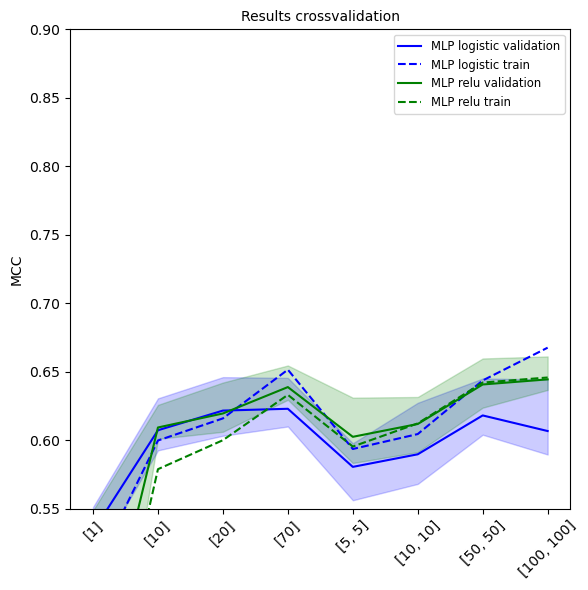

In [37]:
fig, ax = plt.subplots(1, 1, figsize = (6, 6))
# ######################### Logistic 
# Plot results logistic activation function
mean_logistic_test = np.array([res_test_xval_logistic[i, :, learning_logistic[i], 
                           alpha_logistic[i]].mean() for i in range(res_test_xval_logistic.shape[0])])
min_logistic_test = np.array([res_test_xval_logistic[i, :, learning_logistic[i], 
                          alpha_logistic[i]].min() for i in range(res_test_xval_logistic.shape[0])])
max_logistic_test = np.array([res_test_xval_logistic[i, :, learning_logistic[i], 
                          alpha_logistic[i]].max() for i in range(res_test_xval_logistic.shape[0])])

steps = np.arange(len(hidden_layer_sizes))
ax.plot(steps, mean_logistic_test, 'b', label =r'MLP logistic validation')
ax.fill_between(steps, min_logistic_test, max_logistic_test, color = 'blue', alpha=0.2)
mean_logistic_train = np.array([res_train_xval_logistic[i, :, learning_logistic[i], 
                            alpha_logistic[i]].mean() for i in range(res_test_xval_logistic.shape[0])])


steps = np.arange(len(hidden_layer_sizes))
ax.plot(steps, mean_logistic_train, '--b', label = r'MLP logistic train')

# Plot results relu activation function
mean_relu_test = np.array([res_test_xval_relu[i, :, learning_relu[i], 
                           alpha_relu[i]].mean() for i in range(res_test_xval_relu.shape[0])])
min_relu_test = np.array([res_test_xval_relu[i, :, learning_relu[i], 
                          alpha_relu[i]].min() for i in range(res_test_xval_relu.shape[0])])
max_relu_test = np.array([res_test_xval_relu[i, :, learning_relu[i], 
                          alpha_relu[i]].max() for i in range(res_test_xval_relu.shape[0])])

steps = np.arange(len(hidden_layer_sizes))
ax.plot(steps, mean_relu_test, 'g', label = r'MLP relu validation')
ax.fill_between(steps, min_relu_test, max_relu_test, color = 'green', alpha=0.2)

mean_relu_train = np.array([res_train_xval_relu[i, :, learning_relu[i], 
                            alpha_relu[i]].mean() for i in range(res_train_xval_relu.shape[0])])


steps = np.arange(len(hidden_layer_sizes))
ax.plot(steps, mean_relu_train, '--g', label = r'MLP relu train')

ax.set_title('Results crossvalidation', fontsize= 10)

ax.set_ylim(0.55, 0.9)
ax.set_ylabel('MCC')
ax.set_xticks(np.arange(len(hidden_layer_sizes)), [str(hidden_layer_sizes[i]) for i in range(len(hidden_layer_sizes))], rotation = 45)
ax.set_xticks(np.arange(len(hidden_layer_sizes)), [str(hidden_layer_sizes[i]) for i in range(len(hidden_layer_sizes))], rotation = 45)
plt.tight_layout()

ax.legend(fontsize='small', loc='upper right')


## Train MLP using optimal hyperparameters and all CMLs

In [38]:
# prepare TRAIN dataset:
Y_train = np.vstack(np.array([(ds_cmls.sel(cml_id = train_test).isel( 
    cml_id = i, sublink_id = 0).radar_wet).values.reshape(-1, 1) for i in range(
    ds_cmls.sel(cml_id = train_test).cml_id.size)]))

X_train = []
x_start = np.ones([int(windowsize) - 1, windowsize*2])*np.nan
#x_end = np.ones([int(windowsize/2)- 1, windowsize*2])*np.nan

for link_i in range(ds_cmls.sel(cml_id = train_test).cml_id.size):
    sliding_window_ch1 = sliding_window_view(ds_cmls.sel(
        cml_id = train_test).isel(cml_id = link_i, sublink_id = 0).trsl_norm.values, window_shape = windowsize)
    sliding_window_ch2 = sliding_window_view(ds_cmls.sel(
        cml_id = train_test).isel(cml_id = link_i, sublink_id = 1).trsl_norm.values, window_shape = windowsize)

    X_train.append(np.vstack([x_start, np.hstack([sliding_window_ch1, sliding_window_ch2])]))
X_train = np.vstack(X_train)

# remove nan
indices = np.argwhere(~np.isnan(X_train).any(axis = 1)).ravel()
X_train = X_train[indices, :]
Y_train = Y_train[indices]

# # set minutes close to rain as wet, select 50/50 wet dry 
smoothed_rain = smooth_binary_array(Y_train.ravel(), window_size=30)
indices_rain = np.where(smoothed_rain)[0]
indices_norain = np.where(~smoothed_rain)[0]

# select some random dry events
indices_norain = np.random.choice(indices_norain, size = np.sum(smoothed_rain), replace = False, p = None)
X_train = np.vstack([X_train[indices_norain, :], X_train[indices_rain, :]])
Y_train = np.vstack([Y_train[indices_norain, :], Y_train[indices_rain, :]])

Y_onehot = onehot.fit_transform(Y_train)


In [49]:
i =  2# optimal hidden layers, see plot above
hls = hidden_layer_sizes[i]
dnn = MLPClassifier(learning_rate_init= learning_rate[learning_relu[i]],
                        alpha=regularization[alpha_relu[i]], 
                        max_iter=200, 
                        activation='logistic',
                        solver='adam',
                        verbose = False,
                        hidden_layer_sizes=hls)

dnn.fit(X_train, Y_onehot)

/home/erlend/miniforge3/envs/pycomlink-dev/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(activation='logistic', alpha=np.float64(0.175),
              hidden_layer_sizes=[20],
              learning_rate_init=np.float64(0.00031622776601683794))

In [50]:
with open('model_rad_online.pkl','wb') as f:
    pickle.dump(dnn,f)